In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input

DATA_DIR = "data"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATA_DIR,
    labels="inferred",
    label_mode="binary",
    class_names=["benign", "malignant"],
    shuffle=True,
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
image_dataset = image_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

def generate_gradcam_heatmap(
    preprocessed_image_tensor: tf.Tensor, model: tf.keras.Model
) -> tuple[np.ndarray, str]:
    feature_extractor: tf.keras.Model = model.get_layer("efficientnetb0")

    for layer in reversed(feature_extractor.layers):
        if len(layer.output.shape) == 4:
            last_conv_layer_name = layer.name
            break

    last_conv_layer = feature_extractor.get_layer(last_conv_layer_name)
    conv_output_model = tf.keras.Model(
        inputs=feature_extractor.input, outputs=last_conv_layer.output
    )

    head_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = head_input
    layers_after_backbone = model.layers[model.layers.index(feature_extractor) + 1 :]
    for layer in layers_after_backbone:
        x = layer(x)
    classifier_head_model = tf.keras.Model(head_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = conv_output_model(preprocessed_image_tensor)
        tape.watch(conv_outputs)
        preds = classifier_head_model(conv_outputs)
        malignant_logit = preds[:, 0]

    grads = tape.gradient(malignant_logit, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(pooled_grads[:, None, None, :] * conv_outputs, axis=-1)[0]

    heatmap = tf.maximum(cam, 0).numpy()
    heatmap /= heatmap.max() + 1e-8
    return heatmap, last_conv_layer_name

def overlay_heatmap_on_image(
    original_image_array: np.ndarray,
    heatmap: np.ndarray,
    alpha: float = 0.4,
    colormap: str = "jet",
) -> np.ndarray:
    heatmap_uint8 = np.uint8(255 * heatmap)
    cmap = plt.get_cmap(colormap)
    color_map = cmap(np.arange(256))[:, :3]
    colored_heatmap = color_map[heatmap_uint8]

    heatmap_img = image.array_to_img(colored_heatmap).resize(
        (original_image_array.shape[1], original_image_array.shape[0])
    )
    heatmap_arr = image.img_to_array(heatmap_img)

    superimposed = heatmap_arr * alpha + original_image_array
    return np.uint8(superimposed)

Found 7909 files belonging to 2 classes.


Samples per class: {0: 2480, 1: 5429}


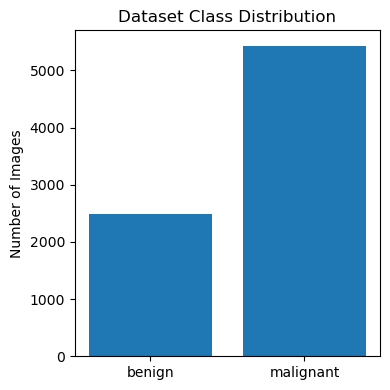

In [2]:
class_counts = {0: 0, 1: 0}

for batch_images, batch_labels in image_dataset:
    unique_labels, counts = np.unique(
        batch_labels.numpy().astype(int), return_counts=True
    )
    for label_id, count in zip(unique_labels, counts):
        class_counts[label_id] += count

print("Samples per class:", class_counts)

plt.figure(figsize=(4, 4))
plt.bar(["benign", "malignant"], [class_counts[0], class_counts[1]])
plt.title("Dataset Class Distribution")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

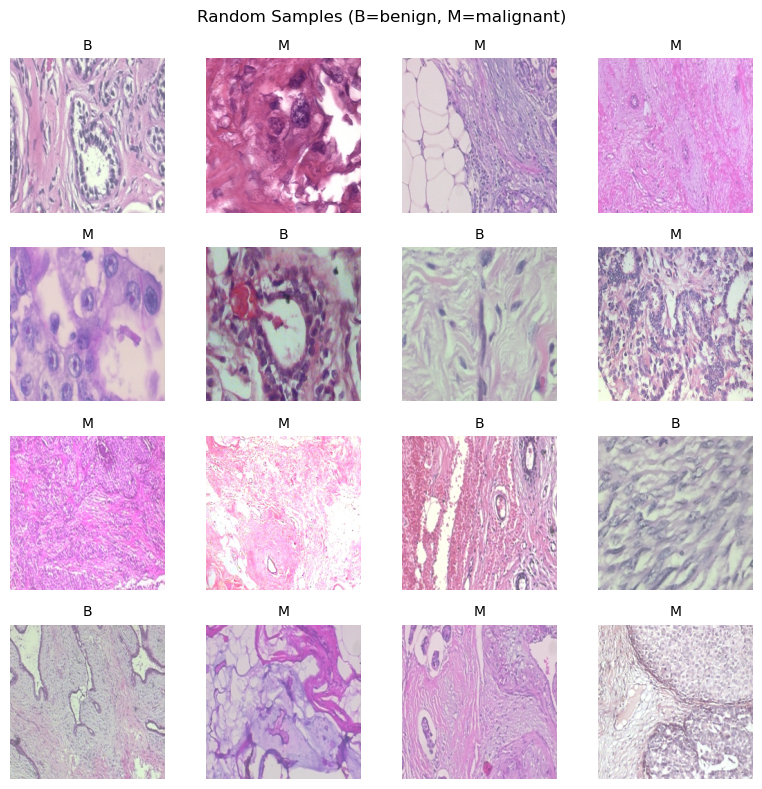

In [3]:
plt.figure(figsize=(8, 8))

for batch_images, batch_labels in (
    image_dataset.unbatch().shuffle(1000).batch(16).take(1)
):
    sample_images = batch_images.numpy().astype("uint8")
    sample_labels = batch_labels.numpy().astype(int)

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    ax.imshow(sample_images[idx])
    ax.set_title("M" if sample_labels[idx] == 1 else "B", fontsize=10)
    ax.axis("off")

plt.suptitle("Random Samples (B=benign, M=malignant)")
plt.tight_layout()
plt.show()

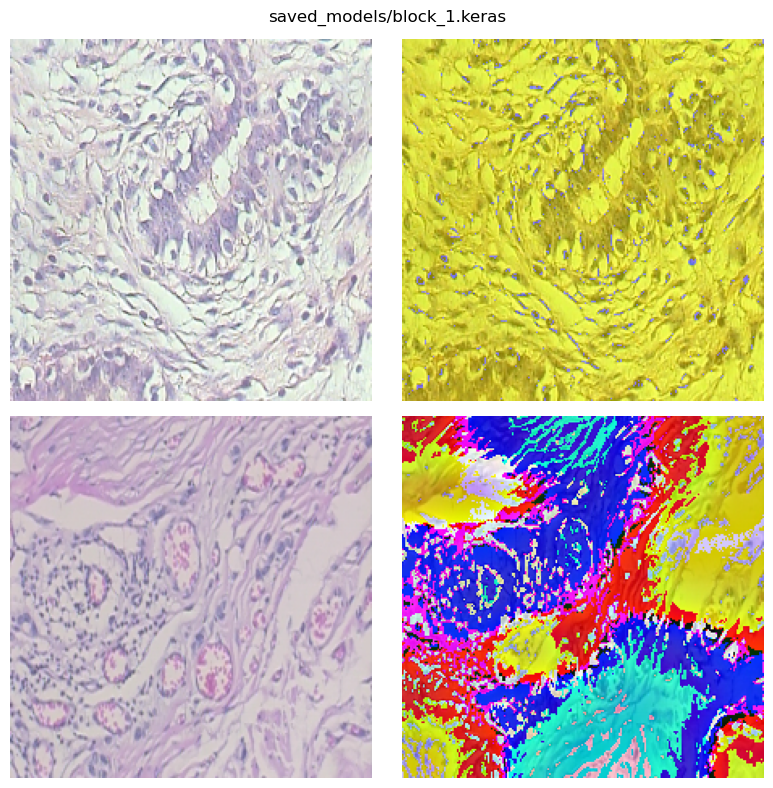

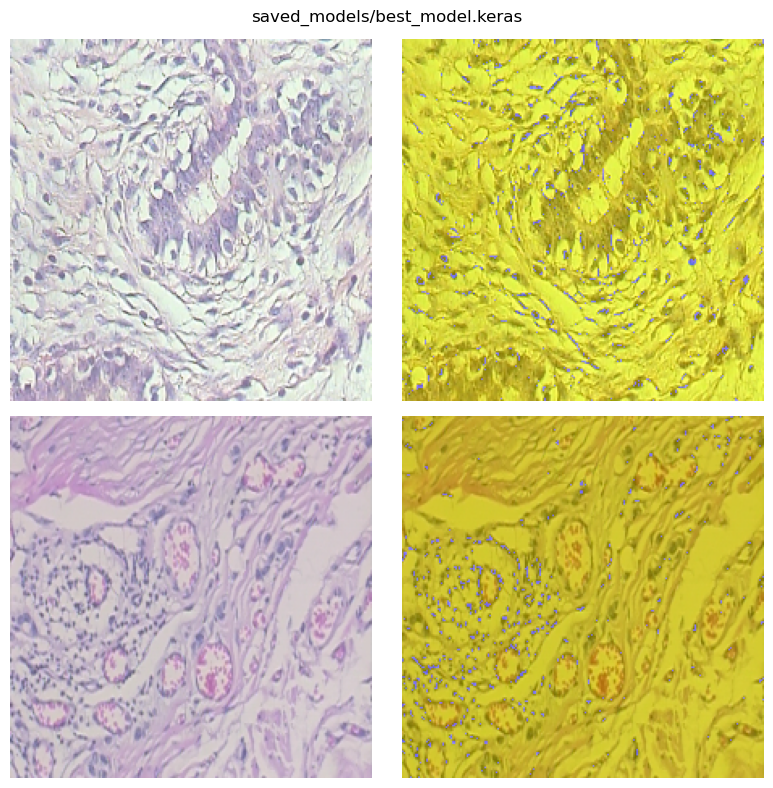

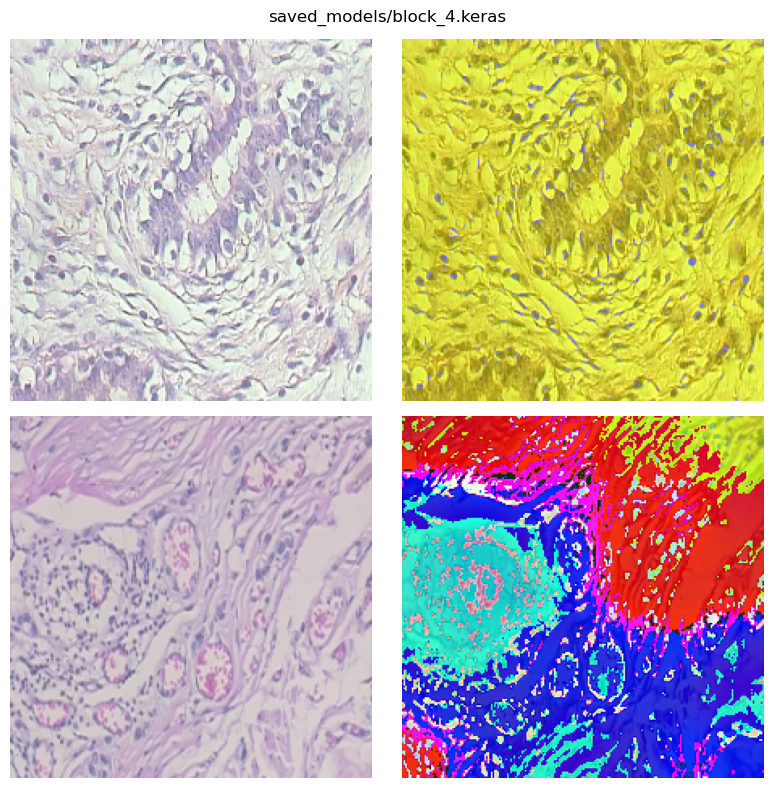

In [18]:
samples = {}
for image_tensor, label_tensor in image_dataset.unbatch():
    label_id = int(label_tensor.numpy().item())
    if label_id not in samples:
        samples[label_id] = image_tensor.numpy().astype("uint8")
    if len(samples) == 2:
        break

model_paths = [
    "saved_models/block_1.keras",
    "saved_models/best_model.keras",
    "saved_models/block_4.keras"
]

for model_path in model_paths:
    classification_model = load_model(model_path)
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for row_index, label_id in enumerate([0, 1]):
        original_image = samples[label_id]
        preprocessed = preprocess_input(original_image[None, ...])
        heatmap, _ = generate_gradcam_heatmap(preprocessed, classification_model)
        overlay_image = overlay_heatmap_on_image(original_image, heatmap)
        axes[row_index, 0].imshow(original_image)
        axes[row_index, 0].axis("off")
        axes[row_index, 1].imshow(overlay_image)
        axes[row_index, 1].axis("off")
    fig.suptitle(model_path)
    plt.tight_layout()
    plt.show()